In [5]:
import yaml
import os
import time
import logging
import cv2
import torchvision

import torch
import torch.optim
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import open3d as o3d
from tensorboardX import SummaryWriter

from utils.utils import getWriterPath, get_log_dir
from settings import EXPER_PATH

## loaders: data, model, pretrained model
from utils.loader import dataLoader, modelLoader, pretrainedLoader
from utils.logging import *
from copy import deepcopy as dc
from utils.d2s import DepthToSpace, SpaceToDepth
from utils.utils import flattenDetection
from Train_model_frontend_cubemap import thd_img

from train_cubemap import *
from utils_custom import *
from utils_custom_visualize import *


seed = 1325
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)


def visualize_kpts(imname1, imname2, kpts1, kpts2, name='_', n=3000):
    if type(imname1) == str:
        im1 = np.array(Image.open(imname1).resize((1024,1024)))
    else:
        im1 = imname1.transpose(0, 1).transpose(1,2).detach().cpu().numpy()
    if type(imname2) == str:
        im2 = np.array(Image.open(imname2).resize((1024,1024)))
    else:
        im2 = imname2.transpose(0, 1).transpose(1,2).detach().cpu().numpy()
    R = 1
    fig, ax = plt.subplots(1, 2) 
    
    ax[0].imshow(im1)
    i = 0

    for x, y in kpts1:
        ax[0].add_patch(plt.Circle((x, y), R, color='r'))
        # ax[0].text(x, y, str(i))
        i += 1
        if i>=n:
            break
            
    i=0
    ax[1].imshow(im2)
    for x, y in kpts2:
        ax[1].add_patch(plt.Circle((x, y), R, color='r'))
        # ax[1].text(x, y, str(i))
        i += 1
        if i>=n:
            break
    plt.title(f'{len(kpts1)}kpts, {len(kpts2)}kpts.')
    plt.savefig(os.path.join(f'{name}.png'))


DBNAME = 'KeyPts2D3D_1024_H100_thd0.2_230417.mat'
# DBNAME = 'KeyPts2D3D_1024_H100_thd0.2_cnt2_test'
RTfile = io.loadmat(DBNAME)

In [6]:
def visualize(imname1, imname2, kpts1=[], kpts2=[], txt1=None, txt2=None, n=3, name='sample'):
    if type(imname1) == str:
        im1, im2 = np.array(Image.open(imname1).resize((1024,1024))), np.array(Image.open(imname2).resize((1024,1024)))
    else:
        im1, im2 = np.array(imname1), np.array(imname2)

    if im1.shape[0] in [1, 3]:
        im1 = np.transpose(im1, (1,2,0))
        im2 = np.transpose(im2, (1,2,0))
    R = 2
    fig, ax = plt.subplots(1, 2) 
    
    ax[0].imshow(im1)
    i = 0
    ref = 300
    interval = 0
    for x, y in kpts1:
        interval += 1
        if interval > ref:
            ax[0].add_patch(plt.Circle((x, y), R, color='r'))
            ax[0].text(x, y, txt1[i])
            print(txt1[i])
            interval = 0
            i += 1
            if i>=n:
                break
            
    print("")
    i=0
    interval = 0
    ax[1].imshow(im2)
    for x, y in kpts2:
        interval += 1
        if interval > ref:
            ax[1].add_patch(plt.Circle((x, y), R, color='r'))
            ax[1].text(x, y, txt2[i])
            print(txt2[i])
            interval = 0
            i += 1
            if i>=n:
                break
    plt.title(f"{len(kpts1)}kpts, {len(kpts2)}kpts")
    plt.savefig(f'{name}.png')

In [92]:
zeros = torch.zeros(2,3)
zeros[0] = 1
zeros

tensor([[1., 1., 1.],
        [0., 0., 0.]])

In [99]:
v, i = zeros.max(0)
v, i

(tensor([1., 1., 1.]), tensor([0, 0, 0]))

In [100]:
zeros.max(0)

torch.return_types.max(
values=tensor([1., 1., 1.]),
indices=tensor([0, 0, 0]))

In [95]:
torch.log(zeros)

tensor([[0., 0., 0.],
        [-inf, -inf, -inf]])

In [7]:

DBNAME = 'KeyPts2D3D_1024_H100_thd0.2_230417.mat'


RTfile key length 2975
484
215
311
307
322
319
232
384
426

--------------------
zzours/cubemaps/setup020/th300.png
zzours/cubemaps/setup026/th175.png
Check the setup.



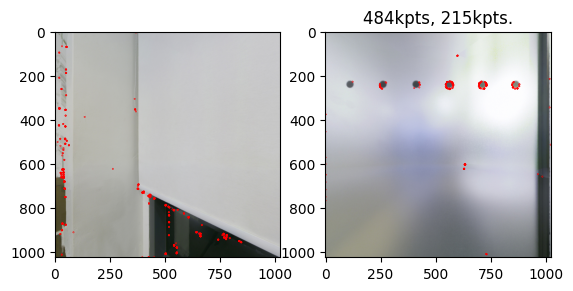

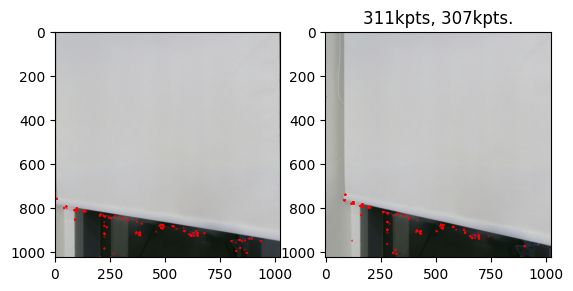

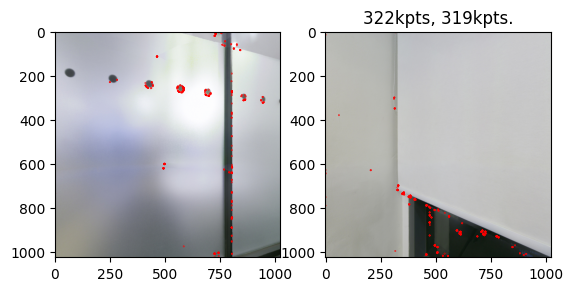

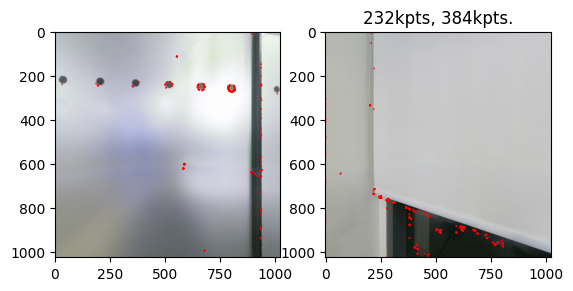

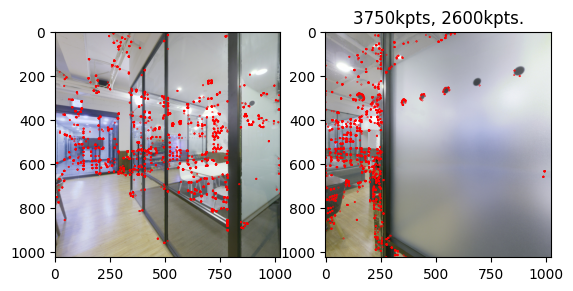

In [11]:
figpath = 'figures/checkdb/'
if not os.path.isdir(figpath):
    os.mkdir(figpath)
    
def show_small_num_case(dbname, thresh=500, N=10):
    RTfile = io.loadmat(dbname)
    namelst = list(RTfile.keys())
    print('RTfile key length', len(namelst))
    srtidx = 4  # 4 이상
    ks = []
    for idx in range(srtidx, len(namelst), 2):
        k = namelst[idx]
    #     k2 = namelst[idx+2]
        if len(torch.Tensor(RTfile[k]))<thresh:
            print(len(torch.Tensor(RTfile[k])))
            ks.append(k)

    if len(ks) == 0:
        print("No small kpt num case")
    for i in range(0, len(ks)-1, 2):
        k = ks[i]
        k2 = ks[i+1]
        ipath = k.split('2D')[0]
        ipath2 = k2.split('2D')[0]
        name=f"{figpath}_{len(os.listdir(figpath))+1}"
        visualize_kpts(ipath, ipath2, torch.Tensor(RTfile[k]), torch.Tensor(RTfile[k2]),
                               name=name)
        if i > N:
            break
        pass
    

def gen_ply(_3dkpts, plypath):
    header = f"""ply
    format ascii 1.0
    element vertex {len(_3dkpts)*4*30-1}             

    comment export ply from pts using python (by vvz3n)
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header"""
    N=30
    ptsstrs = ""
    for kpt3d in _3dkpts:
        for t in range(N):
            t = t/30/100*5
            ptsstrs += f'\n{kpt3d[0]+t} {kpt3d[1]} {kpt3d[2]} 255 0 0'
            ptsstrs += f'\n{kpt3d[0]} {kpt3d[1]+t} {kpt3d[2]} 0 255 0'
            ptsstrs += f'\n{kpt3d[0]} {kpt3d[1]} {kpt3d[2]+t} 0 0 255'
            ptsstrs += f'\n{kpt3d[0]+t} {kpt3d[1]+t} {kpt3d[2]+t} 255 255 0'
    with open(plypath, 'w') as f:
        f.write(header+ptsstrs)
    
def show_kpts_gen_pt_ply(dbname=DBNAME):
    RTfile = io.loadmat(dbname)
    k, k2 = np.random.randint(3, len(list(RTfile.keys())), 2)
    
    ipath = list(RTfile.keys())[k].split('.')[0]+'.png'
    ipath2 = list(RTfile.keys())[k2].split('.')[0]+'.png'
    print(f"\n{'-'*20}\n{ipath}\n{ipath2}\nCheck the setup.\n")
    name = 'sample'
    visualize_kpts(ipath, ipath2, torch.Tensor(RTfile[ipath+'2Dkpts']), torch.Tensor(RTfile[ipath2+'2Dkpts']),
                           name=name, n=10000)
    ply1path = 'zzours/ply/fortest/pt1.ply'
    ply2path = 'zzours/ply/fortest/pt2.ply'
    
    gen_ply(RTfile[ipath+'_3Dkpts'], ply1path)
    gen_ply(RTfile[ipath2+'_3Dkpts'], ply2path)

    
show_small_num_case(DBNAME)

show_kpts_gen_pt_ply(DBNAME)